# Personal Model

*With this notebook we try a new personal model. The goal of this "personal" model, is to have a more hand-on work and try to adjust parameters manually. By transforming the Difficulty levels into numeric values, we can try to compute feature values and through them, compute a new score for each sentence.*

In this third and last notebook we do some final and more advanced feature adjustements and some more detailed preprocessing.
The feature we add to this version is the number of cognates per sentence. The goal is to include the impact that any cognate can have on a sentence. We do that by standardizing the number of cognates per sentence and then giving it a certain weight to use it for the computation of the new Score. We do the same weight operation for the other features as well.

Here, again, we use a reduced version of the train dataset from AICrowd, only now we load the test dataset also.

### Installing and importing the necessary libraries and packages

In [ ]:
!pip install unidecode
!pip install textstat

     |████████████████████████████████| 245kB 7.5MB/s 
     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 1.9MB 13.1MB/s 


In [ ]:
!pip install wordstats
!pip install nltk
!pip install spacy download fr

     |████████████████████████████████| 3.6MB 7.6MB/s 
  Created wheel for wordstats: filename=wordstats-1.0.7-cp37-none-any.whl size=3616377 sha256=0f804505f7180107c9a2fd982425685ab85f86ba11fb6f8618d3398fd387cb40
  Stored in directory: /root/.cache/pip/wheels/19/cd/63/4f1be9b37f67fd5f305b3c7ac88fc8afdb88638589cfa37184
  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=199154a38f90eb115c4e7e510d5973775f110e202e257df2bd581a0bd059b4e2
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built wordstats configobj
     |████████████████████████████████| 14.7MB 7.6MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=6fc7f88f75024896806703b361c06e901b6d6d80521fe078c6b975a01423853b
  Stored in directory: /tmp/pip-ephem-wheel-cache-l10ovbfj/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-

In [ ]:
!spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp37-none-any.whl size=90338490 sha256=088f003524a78c20b3e2ab12126299029655aa1d32cbee05c8fc3777b7b778fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-3hqw9cti/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
import fr_core_news_md

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import string
from wordstats import Word, common_words
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import textstat
nltk.download('punkt')
textstat.set_lang(lang="fr")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading both datasets

In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/aicrowd/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/aicrowd/test.csv")

In [ ]:
df_train.head(5)

,sentence,difficulty
0,C'est pour quand ?,A1
1,Je pense que c'est bon.,A1
2,C'est pas mal.,A1
3,Qu'est-ce que vous faites ?,A1
4,C'est bien !,A1


### The dataset is too large and takes a lot of memory, so we decided to reduce it, from 4800 to 1200

The goal is to keep a still large enough dataset while keeping the same proportion for each category as the original dataset

In [ ]:
df_train = df_train.drop(range(4199,4799))

In [ ]:
df_train = df_train.drop(range(3399,3999))

In [ ]:
df_train = df_train.drop(range(2599,3199))

In [ ]:
df_train = df_train.drop(range(1799,2399))

In [ ]:
df_train = df_train.drop(range(999,1599))

In [ ]:
df_train = df_train.drop(range(199,799))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    1200 non-null   object
 1   difficulty  1200 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB


In [ ]:
df_train.rename({'sentence' : 'Text'}, axis=1, inplace=True)

In [ ]:
df_test.rename({'sentence' : 'Text'}, axis=1, inplace=True)

In [ ]:
df_train.rename({'difficulty' : 'Difficulty'}, axis=1, inplace=True)

In [ ]:
df_test.rename({'difficulty' : 'Difficulty'}, axis=1, inplace=True)

In [ ]:
df_train.Text = df_train.Text.astype('str')

In [ ]:
df_test.Text = df_test.Text.astype('str')

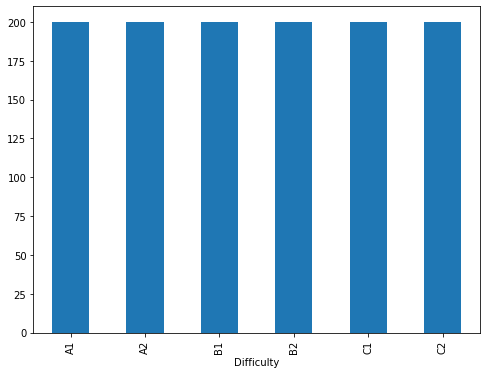

In [ ]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('Difficulty').Text.count().plot.bar(ylim=0)
plt.show()

### Transform Categories into numeric values 

In [ ]:
df_train = df_train.replace(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [1,2,3,4,5,6])

In [ ]:
df_test = df_test.replace(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [1,2,3,4,5,6])

In [ ]:
df_train.head(5)

,Text,Difficulty
0,C'est pour quand ?,1
1,Je pense que c'est bon.,1
2,C'est pas mal.,1
3,Qu'est-ce que vous faites ?,1
4,C'est bien !,1


In [ ]:
# pour plus tard
#df.Difficulty = pd.cut(df.Difficulty, bins=[0,1,2,3,4,5, 6], labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

##Preprocessing 
###remove 1-letter words that augment the difficulty score unnecessarily 

In [ ]:
df_train.Text = df_train['Text'].str.findall('\w{2,}').str.join(' ')

In [ ]:
df_test.Text = df_test['Text'].str.findall('\w{2,}').str.join(' ')

In [ ]:
df_test.head(5)

,Text
0,Il est devenu courant de déplorer que la Franc...
1,Sur les flancs et les derrières de la noce tou...
2,aime aussi beaucoup sa voix une voix un peu gr...
3,En partenariat avec INPES Institut National de...
4,Il se réveilla seulement quand il entendit un ...


## Feature augmentation
Separate the words, in order to get the difficulty per word

In [ ]:
df_train["Word"] = ""

In [ ]:
df_test["Word"] = ""

In [ ]:
sp = fr_core_news_md.load()
len = df_train.shape[0]
ligne = 0
while ligne<len:
  text = str(df_train["Text"].iloc[ligne])
  theDoc = sp(text)
  token_list = []
  new_List = []
  for w in theDoc:
    token_list.append(w.text)
    if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
      token_list.remove(w.text)
  df_train["Word"].iloc[ligne] = token_list
  ligne += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
sp = fr_core_news_md.load()
len = df_test.shape[0]
ligne = 0
while ligne<len:
  text = str(df_test["Text"].iloc[ligne])
  theDoc = sp(text)
  token_list = []
  new_List = []
  for w in theDoc:
    token_list.append(w.text)
    if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
      token_list.remove(w.text)
  df_test["Word"].iloc[ligne] = token_list
  ligne += 1

In [ ]:
df_train["Types"] = ""
line = 0
while line<len:
  my_list = []
  text = df_train['Text'].iloc[line]
  my_doc = sp(text)
  for w in my_doc: 
    my_list.append(w.pos_)
  df_train['Types'].iloc[line] = my_list
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_test["Types"] = ""
line = 0
while line<len:
  my_list = []
  text = df_test['Text'].iloc[line]
  my_doc = sp(text)
  for w in my_doc: 
    my_list.append(w.pos_)
  df_test['Types'].iloc[line] = my_list
  line += 1

In [ ]:
df_train.head(15)

,Text,Difficulty,Word,Types
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]"
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]"
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]"
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]"
4,est bien,1,"[est, bien]","[AUX, ADV]"
5,Ce est pas juste,1,"[Ce, est, pas, juste]","[PRON, AUX, ADV, ADV]"
6,Je ne veux pas,1,"[Je, ne, veux, pas]","[PRON, ADV, VERB, ADV]"
7,Je ne sais pas,1,"[Je, ne, sais, pas]","[PRON, ADV, VERB, ADV]"
8,Plus que ça,1,"[Plus, que, ça]","[ADV, SCONJ, PRON]"
9,Non je ne le trouve pas,1,"[Non, je, ne, le, trouve, pas]","[ADV, PRON, ADV, PRON, VERB, ADV]"


In [ ]:
df_test.head(15)

,Text,Word,Types
0,Il est devenu courant de déplorer que la Franc...,"[Il, est, devenu, courant, de, déplorer, que, ...","[PRON, AUX, AUX, VERB, ADP, VERB, SCONJ, DET, ..."
1,Sur les flancs et les derrières de la noce tou...,"[Sur, les, flancs, et, les, derrières, de, la,...","[ADP, DET, NOUN, CCONJ, DET, NOUN, ADP, DET, N..."
2,aime aussi beaucoup sa voix une voix un peu gr...,"[aime, aussi, beaucoup, sa, voix, une, voix, u...","[VERB, ADV, ADV, DET, NOUN, DET, NOUN, DET, AD..."
3,En partenariat avec INPES Institut National de...,"[En, partenariat, avec, Institut, National, de...","[ADP, NOUN, ADP, PROPN, X, ADJ, ADP, NOUN, CCO..."
4,Il se réveilla seulement quand il entendit un ...,"[Il, se, réveilla, seulement, quand, il, enten...","[PRON, PRON, VERB, ADV, SCONJ, PRON, VERB, DET..."
5,Illusion de ignoble qui attire tant êtres,"[Illusion, de, ignoble, qui, attire, tant, êtres]","[NOUN, ADP, NOUN, PRON, VERB, ADV, ADJ]"
6,objectif est de proposer aux élèves des techni...,"[objectif, est, de, proposer, aux, élèves, des...","[NOUN, AUX, ADP, VERB, ADV, NOUN, DET, NOUN, V..."
7,Par ailleurs le concept echelle architecturolo...,"[Par, ailleurs, le, concept, constitue, un, ou...","[ADP, ADV, DET, NOUN, PROPN, PROPN, VERB, DET,..."
8,ai grandi dans une famille binationale mon pèr...,"[ai, grandi, dans, une, famille, binationale, ...","[AUX, VERB, ADP, DET, NOUN, ADJ, DET, NOUN, AU..."
9,Évaluant intérêt croissant porté son récit hom...,"[Évaluant, intérêt, croissant, porté, son, réc...","[VERB, NOUN, ADJ, VERB, DET, NOUN, NOUN, ADP, ..."


In [ ]:
df_train["WordDifficulty"] = ""
df_train["AvgWordDiffic"] = ""

In [ ]:
df_test["WordDifficulty"] = ""
df_test["AvgWordDiffic"] = ""

In [ ]:
df_train.head(10)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]",,
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]",,
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]",,
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]",,
4,est bien,1,"[est, bien]","[AUX, ADV]",,
5,Ce est pas juste,1,"[Ce, est, pas, juste]","[PRON, AUX, ADV, ADV]",,
6,Je ne veux pas,1,"[Je, ne, veux, pas]","[PRON, ADV, VERB, ADV]",,
7,Je ne sais pas,1,"[Je, ne, sais, pas]","[PRON, ADV, VERB, ADV]",,
8,Plus que ça,1,"[Plus, que, ça]","[ADV, SCONJ, PRON]",,
9,Non je ne le trouve pas,1,"[Non, je, ne, le, trouve, pas]","[ADV, PRON, ADV, PRON, VERB, ADV]",,


In [ ]:
df_train.head(10)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]",,
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]",,
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]",,
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]",,
4,est bien,1,"[est, bien]","[AUX, ADV]",,
5,Ce est pas juste,1,"[Ce, est, pas, juste]","[PRON, AUX, ADV, ADV]",,
6,Je ne veux pas,1,"[Je, ne, veux, pas]","[PRON, ADV, VERB, ADV]",,
7,Je ne sais pas,1,"[Je, ne, sais, pas]","[PRON, ADV, VERB, ADV]",,
8,Plus que ça,1,"[Plus, que, ça]","[ADV, SCONJ, PRON]",,
9,Non je ne le trouve pas,1,"[Non, je, ne, le, trouve, pas]","[ADV, PRON, ADV, PRON, VERB, ADV]",,


In [ ]:
line = 0 
len = df_train.shape[0]
while line<len:
  newList = []
  for w in df_train.Word.iloc[line]:
    newList.append(Word.stats(w, "fr").difficulty)
  df_train.WordDifficulty.iloc[line] = newList
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
line = 0 
len = df_test.shape[0]
while line<len:
  newList = []
  for w in df_test.Word.iloc[line]:
    newList.append(Word.stats(w, "fr").difficulty)
  df_test.WordDifficulty.iloc[line] = newList
  line += 1

In [ ]:
# Get the average word difficulty
line = 0 
len = df_train.shape[0]
while line<len:
  total = 0
  nb = 0
  for i in df_train.WordDifficulty.iloc[line]:
    total += i
    nb += 1
    df_train.AvgWordDiffic.iloc[line] = total/nb 
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# Get the average word difficulty
line = 0 
len = df_test.shape[0]
while line<len:
  total = 0
  nb = 0
  for i in df_test.WordDifficulty.iloc[line]:
    total += i
    nb += 1
    df_test.AvgWordDiffic.iloc[line] = total/nb 
  line += 1

Preprocessing - remove punctuation

In [ ]:
punct = string.punctuation

In [ ]:
line = 0 
len = df_train.shape[0]
while line<len:
  diffic = df_train.Word.iloc[line]
  for i in diffic:
    if (i in punct):
      diffic.remove(i)
  line += 1

In [ ]:
line = 0 
len = df_test.shape[0]
while line<len:
  diffic = df_test.Word.iloc[line]
  for i in diffic:
    if (i in punct):
      diffic.remove(i)
  line += 1

In [ ]:
df_train.head(10)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0
5,Ce est pas juste,1,"[Ce, est, pas, juste]","[PRON, AUX, ADV, ADV]","[0.0, 0.0, 0.0, 0.0]",0
6,Je ne veux pas,1,"[Je, ne, veux, pas]","[PRON, ADV, VERB, ADV]","[0.0, 0.0, 0.0, 0.0]",0
7,Je ne sais pas,1,"[Je, ne, sais, pas]","[PRON, ADV, VERB, ADV]","[0.0, 0.0, 0.0, 0.0]",0
8,Plus que ça,1,"[Plus, que, ça]","[ADV, SCONJ, PRON]","[0.0, 0.0, 0.0]",0
9,Non je ne le trouve pas,1,"[Non, je, ne, le, trouve, pas]","[ADV, PRON, ADV, PRON, VERB, ADV]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0


Get the word frequency score

In [ ]:
df_train["WordFrequency"] = ""
line = 0
while line<len:
  new_List = []
  for w in df_train.Word.iloc[line]:
    new_List.append(Word.stats(w, "fr").frequency)
  df_train.WordFrequency.iloc[line] = new_List
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_test["WordFrequency"] = ""
line = 0
while line<len:
  new_List = []
  for w in df_test.Word.iloc[line]:
    new_List.append(Word.stats(w, "fr").frequency)
  df_test.WordFrequency.iloc[line] = new_List
  line += 1

In [ ]:
df_train.head()

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0,"[15.6, 14.57, 13.15]"
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0,"[15.78, 12.24, 15.29, 15.6, 12.93]"
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0,"[15.6, 15.43, 12.15]"
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]"
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0,"[15.6, 14.03]"


In [ ]:
# Get the average word frequency per sentence
df_train["AvgFreq"] = ""
line = 0
while line<len:
  tot = 0
  nb = 0
  for i in df_train.WordFrequency.iloc[line]:
    tot += i
    nb += 1
    df_train.AvgFreq.iloc[line] = tot/nb
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# Get the average word frequency per sentence
df_test["AvgFreq"] = ""
line = 0
while line<len:
  tot = 0
  nb = 0
  for i in df_test.WordFrequency.iloc[line]:
    tot += i
    nb += 1
    df_test.AvgFreq.iloc[line] = tot/nb
  line += 1

In [ ]:
df_train.head()

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0,"[15.6, 14.57, 13.15]",14.44
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0,"[15.78, 12.24, 15.29, 15.6, 12.93]",14.368
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0,"[15.6, 15.43, 12.15]",14.3933
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]",13.5717
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0,"[15.6, 14.03]",14.815


In [ ]:
df_train.dtypes

Text              object
Difficulty         int64
Word              object
Types             object
WordDifficulty    object
AvgWordDiffic     object
WordFrequency     object
AvgFreq           object
dtype: object

In [ ]:
df_train.AvgFreq = pd.to_numeric(df_train.AvgFreq)
df_train.AvgWordDiffic = pd.to_numeric(df_train.AvgWordDiffic)
df_test.AvgFreq = pd.to_numeric(df_test.AvgFreq)
df_test.AvgWordDiffic = pd.to_numeric(df_test.AvgWordDiffic)

Get the Readability score

In [ ]:
df_train["ReadScore"] = ""
df_test["ReadScore"] = ""
df_train["ReadScore"] = df_train.Text.apply(textstat.flesch_reading_ease)
df_test["ReadScore"] = df_test.Text.apply(textstat.flesch_reading_ease)

In [ ]:
df_train.dtypes

Text               object
Difficulty          int64
Word               object
Types              object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
ReadScore         float64
dtype: object

In [ ]:
df_train.head()

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,ReadScore
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0.000,"[15.6, 14.57, 13.15]",14.440000,130.36
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000,"[15.78, 12.24, 15.29, 15.6, 12.93]",14.368000,128.33
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0.000,"[15.6, 15.43, 12.15]",14.393333,130.36
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]",13.571667,127.31
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0.000,"[15.6, 14.03]",14.815000,131.37


## Adding the cognates

In [ ]:
cognates = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/cognates.csv")
cognates.head(10)

,Cognates
0,abandon
1,abbé
2,abdomen
3,abdominal
4,aberration
5,abolition
6,abominable
7,abondance
8,abondant
9,absence


In [ ]:
line = 0
len = cognates.shape[0]
cog_list = []
while line<len:
  text = str(cognates.Cognates.iloc[line])
  my_doc = sp(text)
  for i in my_doc:
    cog_list.append(i.text)
  line += 1

In [ ]:
df_train["Cognates"] = ""
df_train["cog"] = ""
line = 0
len = cognates.shape[0]
while line<len:
  list_cog = []
  num_cog = []
  for i in df_train.Word.iloc[line]:
    if i in cog_list:
      list_cog.append(i)
      df_train.Cognates.iloc[line] = list_cog
    if i in cog_list:
      num_cog.append(1)
      df_train.cog.iloc[line] = num_cog
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_test["Cognates"] = ""
df_test["cog"] = ""
line = 0
len = cognates.shape[0]
while line<len:
  list_cog = []
  num_cog = []
  for i in df_test.Word.iloc[line]:
    if i in cog_list:
      list_cog.append(i)
      df_test.Cognates.iloc[line] = list_cog
    if i in cog_list:
      num_cog.append(1)
      df_test.cog.iloc[line] = num_cog
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_train.head(20)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,ReadScore,Cognates,cog
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0.000000,"[15.6, 14.57, 13.15]",14.440000,130.36,,
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,"[15.78, 12.24, 15.29, 15.6, 12.93]",14.368000,128.33,,
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0.000000,"[15.6, 15.43, 12.15]",14.393333,130.36,,
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005000,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]",13.571667,127.31,,
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0.000000,"[15.6, 14.03]",14.815000,131.37,,
5,Ce est pas juste,1,"[Ce, est, pas, juste]","[PRON, AUX, ADV, ADV]","[0.0, 0.0, 0.0, 0.0]",0.000000,"[14.59, 15.6, 15.43, 12.9]",14.630000,129.34,,
6,Je ne veux pas,1,"[Je, ne, veux, pas]","[PRON, ADV, VERB, ADV]","[0.0, 0.0, 0.0, 0.0]",0.000000,"[15.78, 14.87, 13.37, 15.43]",14.862500,129.34,,
7,Je ne sais pas,1,"[Je, ne, sais, pas]","[PRON, ADV, VERB, ADV]","[0.0, 0.0, 0.0, 0.0]",0.000000,"[15.78, 14.87, 13.51, 15.43]",14.897500,129.34,,
8,Plus que ça,1,"[Plus, que, ça]","[ADV, SCONJ, PRON]","[0.0, 0.0, 0.0]",0.000000,"[13.85, 15.29, 14.67]",14.603333,130.36,,
9,Non je ne le trouve pas,1,"[Non, je, ne, le, trouve, pas]","[ADV, PRON, ADV, PRON, VERB, ADV]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,"[13.91, 15.78, 14.87, 15.33, 11.15, 15.43]",14.411667,127.31,,


## Regulate the cognates 
convert array "Cognates" with cognates into string








In [ ]:
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))
        

In [ ]:
df_train["cog"] = df_train["Cognates"].apply(listToString)

In [ ]:
df_test["cog"] = df_test["Cognates"].apply(listToString)

Create a True or False column for the cognates 

In [ ]:
df_train['hasCog'] = np.where(df_train['cog']!= '', True, False)

In [ ]:
df_test['hasCog'] = np.where(df_test['cog']!= '', True, False)

Convert True and False into 1 and 0

In [ ]:
df_train.hasCog = df_train.hasCog.replace([True, False], [1,0])
df_test.hasCog = df_test.hasCog.replace([True, False], [1,0])

In [ ]:
df_train.hasCog.value_counts()

0    825
1    375
Name: hasCog, dtype: int64

In [ ]:
df_train.dtypes

Text               object
Difficulty          int64
Word               object
Types              object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
ReadScore         float64
Cognates           object
cog                object
hasCog              int64
dtype: object

In [ ]:
df_train.head(5)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,ReadScore,Cognates,cog,hasCog,NumOfCog
0,est pour quand,1,"[est, pour, quand]","[AUX, ADP, SCONJ]","[0.0, 0.0, 0.0]",0.000,"[15.6, 14.57, 13.15]",14.440000,130.36,,,0,0
1,Je pense que est bon,1,"[Je, pense, que, est, bon]","[PRON, VERB, SCONJ, AUX, ADJ]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000,"[15.78, 12.24, 15.29, 15.6, 12.93]",14.368000,128.33,,,0,0
2,est pas mal,1,"[est, pas, mal]","[AUX, ADV, NOUN]","[0.0, 0.0, 0.0]",0.000,"[15.6, 15.43, 12.15]",14.393333,130.36,,,0,0
3,Qu est ce que vous faites,1,"[Qu, est, ce, que, vous, faites]","[PRON, AUX, PRON, PRON, PRON, VERB]","[0.03, 0.0, 0.0, 0.0, 0.0, 0.0]",0.005,"[9.21, 15.6, 14.59, 15.29, 15.16, 11.58]",13.571667,127.31,,,0,0
4,est bien,1,"[est, bien]","[AUX, ADV]","[0.0, 0.0]",0.000,"[15.6, 14.03]",14.815000,131.37,,,0,0


Get number of cognates per sentence


In [ ]:
df_train['NumOfCog'] = df_train['cog'].str.split().str.len()

In [ ]:
df_test['NumOfCog'] = df_test['cog'].str.split().str.len()

Standardization of the numarical values

In [ ]:
n_train = df_train.copy()
cols_to_norm = ['ReadScore']
n_train[cols_to_norm]=(n_train[cols_to_norm]-n_train[cols_to_norm].min())/(n_train[cols_to_norm].max()-n_train[cols_to_norm].min())

In [ ]:
n_test = df_train.copy()
cols_to_norm = ['ReadScore']
n_test[cols_to_norm]=(n_test[cols_to_norm]-n_test[cols_to_norm].min())/(n_test[cols_to_norm].max()-n_test[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgFreq']
n_train[cols_to_norm]=(n_train[cols_to_norm]-n_train[cols_to_norm].min())/(n_train[cols_to_norm].max()-n_train[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgFreq']
n_test[cols_to_norm]=(n_test[cols_to_norm]-n_test[cols_to_norm].min())/(n_test[cols_to_norm].max()-n_test[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgWordDiffic']
n_train[cols_to_norm]=(n_train[cols_to_norm]-n_train[cols_to_norm].min())/(n_train[cols_to_norm].max()-n_train[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgWordDiffic']
n_test[cols_to_norm]=(n_test[cols_to_norm]-n_test[cols_to_norm].min())/(n_test[cols_to_norm].max()-n_test[cols_to_norm].min())

In [ ]:
cols_to_norm = ['NumOfCog']
n_train[cols_to_norm]=(n_train[cols_to_norm]-n_train[cols_to_norm].min())/(n_train[cols_to_norm].max()-n_train[cols_to_norm].min())

In [ ]:
cols_to_norm = ['NumOfCog']
n_test[cols_to_norm]=(n_test[cols_to_norm]-n_test[cols_to_norm].min())/(n_test[cols_to_norm].max()-n_test[cols_to_norm].min())

In [ ]:
n_train.head()

Reverse some values for computation purposes

In [ ]:
def get_negative(x):
	return 1 - x

In [ ]:
n_train["AvgFreqStd"] = n_train["AvgFreq"].apply(get_negative)
n_test["AvgFreqStd"] = n_test["AvgFreq"].apply(get_negative)

In [ ]:
n_train["ReadScoreStd"] = n_train["ReadScore"].apply(get_negative)
n_test["ReadScoreStd"] = n_test["ReadScore"].apply(get_negative)

### Create a new dataset with only the necessary columns

In [ ]:
train = n_train[['Text','AvgFreqStd','AvgWordDiffic', 'ReadScoreStd', 'NumOfCog']].copy()

In [ ]:
test = n_test[['Text','AvgFreqStd','AvgWordDiffic', 'ReadScoreStd', 'NumOfCog']].copy()

In [ ]:
train.head()

,Text,AvgFreqStd,AvgWordDiffic,ReadScoreStd,NumOfCog
0,est pour quand,0.040516,0.000,0.010126,0.0
1,Je pense que est bon,0.046892,0.000,0.020251,0.0
2,est pas mal,0.044648,0.000,0.010126,0.0
3,Qu est ce que vous faites,0.117414,0.007,0.025339,0.0
4,est bien,0.007306,0.000,0.005088,0.0


## Compute new Difficulty Score
put weights on the features

In [ ]:
def get_weight(x):
	return 0.1 * x

In [ ]:
train["NumOfCog"] = train["NumOfCog"].apply(get_weight)
test["NumOfCog"] = test["NumOfCog"].apply(get_weight)

Create new column with the new computed numeric Scores

In [ ]:
train['Score'] = train['AvgFreqStd'] + train['AvgWordDiffic'] + train['ReadScoreStd'] - train['NumOfCog']
#test['Score'] = test['AvgFreqStd'] + test['AvgWordDiffic'] + test['ReadScoreStd'] + test['NumOfCog']

In [ ]:
# Standardize the Score column
cols_to_norm = ['Score']
train[cols_to_norm]=(train[cols_to_norm]-train[cols_to_norm].min())/(train[cols_to_norm].max()-train[cols_to_norm].min())

In [ ]:
train.Score.isnull().sum()

1

In [ ]:
# Fill NaN values
bbb = train[train['Score'].isna()]
bbb

,Text,AvgFreqStd,AvgWordDiffic,ReadScoreStd,NumOfCog,Score
3200,Parbleu,NaN,NaN,0.367119,0.0,NaN


In [ ]:
train['Score'] = train['Score'].fillna(1)

In [ ]:
#cols_to_norm = ['Score']
#test[cols_to_norm]=(test[cols_to_norm]-test[cols_to_norm].min())/(test[cols_to_norm].max()-test[cols_to_norm].min())

## Transform back to Categorical values

In [ ]:
train.Score = pd.cut(train.Score, bins=[0,0.095,0.15,0.255,0.4,0.51,1], labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

In [ ]:
train.Score.value_counts()

C2    206
C1    205
A2    205
B1    198
A1    198
B2    187
Name: Score, dtype: int64

In [ ]:
train.head()

,Text,AvgFreqStd,AvgWordDiffic,ReadScoreStd,NumOfCog,Score
0,est pour quand,0.040516,0.000,0.010126,0.0,A1
1,Je pense que est bon,0.046892,0.000,0.020251,0.0,A1
2,est pas mal,0.044648,0.000,0.010126,0.0,A1
3,Qu est ce que vous faites,0.117414,0.007,0.025339,0.0,A1
4,est bien,0.007306,0.000,0.005088,0.0,NaN


In [ ]:
train['Score'].isnull().sum()

1

In [ ]:
bbb = train[train['NumOfCog'].isna()]

In [ ]:
bbb

,Text,AvgFreqStd,AvgWordDiffic,ReadScoreStd,NumOfCog,Score


In [ ]:
train['AvgWordDiffic'] = train['AvgWordDiffic'].fillna(1)

## Train and Test split & Model testing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
def evaluate(true, pred):
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [ ]:
X = train[['AvgFreqStd','AvgWordDiffic','ReadScoreStd','NumOfCog']]
y = train.Score

In [ ]:
X.isnull().sum()

AvgFreqStd       0
AvgWordDiffic    0
ReadScoreStd     0
NumOfCog         0
dtype: int64

In [ ]:
y.isna().sum()

0

In [ ]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [ ]:
X_train.value_counts()

In [ ]:
X_train = np.array(X_train)  
X_test = np.array(X_test)  

Classifier Model

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=72)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=72, verbose=0,
                       warm_start=False)

In [ ]:
pred = RF.predict(X_test)

In [ ]:
evaluate(y_test, pred)

CONFUSION MATRIX:
[[33  0  0  0  0  0]
 [18 13  7  0  0  0]
 [ 2  3 34  3  1  0]
 [ 0  0  5 21 15  0]
 [ 0  0  0  0 33  6]
 [ 0  0  0  0  1 45]]
ACCURACY SCORE:
0.7458
CLASSIFICATION REPORT:
	Precision: 0.7653
	Recall: 0.7449
	F1_Score: 0.7214


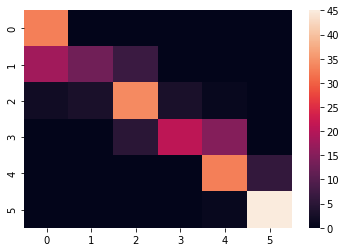

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred))

Regression Model

In [ ]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [ ]:
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[33  0  0  0  0  0]
 [12 26  0  0  0  0]
 [ 0 20 21  2  0  0]
 [ 0  0  6 20 15  0]
 [ 0  0  0  0 37  2]
 [ 0  0  0  0  0 46]]
ACCURACY SCORE:
0.7625
CLASSIFICATION REPORT:
	Precision: 0.7759
	Recall: 0.7682
	F1_Score: 0.7487


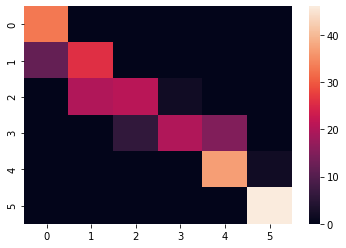

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [ ]:
y_pred1 = LR.predict(test[['AvgFreqStd','AvgWordDiffic','ReadScoreStd','NumOfCog']])

In [ ]:
y_pred1.shape

(1200,)

In [ ]:
pred1 = RF.predict(test[['AvgFreqStd','AvgWordDiffic','ReadScoreStd','NumOfCog']])

In [ ]:
pred1.shape

(1200,)